In [25]:
import pandas as pd
import json
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
%config IPCompleter.greedy = True
import matplotlib.pyplot as plt
%matplotlib inline

Будем предсказывать зарплату по описанию вакансии - это задача регрессии!

In [26]:
df = pd.read_csv("salary_data_cleaned.csv")

In [27]:
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0


Посмотрим на распределение целевой переменной

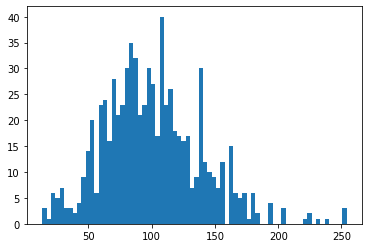

In [5]:
plt.hist(df.avg_salary, bins=70)
plt.show()

Похоже на нормальное. Лучший вариант для линейной регрессии :)

Закодируйте колонку "Job Description" при помощи tf-idf

*  попробуйте подобрать гиперпараметры min_df, max_df, ngram_range у метода для достижения наилучшего качества модели

In [11]:
%%time
tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 1))
f = tfidf.fit_transform(df["Job Description"])

CPU times: user 541 ms, sys: 6.91 ms, total: 548 ms
Wall time: 704 ms


In [12]:
print(f.shape)

(742, 4640)


In [13]:
pd.DataFrame(f[:10, :].todense(), columns=tfidf.get_feature_names()).head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,02,03,04,05,10,100,101,11,12,...,yield,yoga,york,you,youll,your,yourself,youtube,yrs,zero
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.056344,0.0,0.0,0.0,...,0.0,0.0,0.0,0.023097,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.028205,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.022376,0.0,0.0,0.0,0.0
3,0.0,0.0,0.060139,0.061591,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.030099,0.0,0.019088,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.038564,0.0,0.024457,0.0,0.0,0.0,0.0


In [30]:
%%time
trX, teX, trY, teY = train_test_split(f, df["avg_salary"], test_size=0.2)
clf = Ridge(alpha=1.1)
clf.fit(trX, trY)

CPU times: user 17.8 ms, sys: 2.93 ms, total: 20.7 ms
Wall time: 20.8 ms


Ridge(alpha=1.1)

In [29]:
print("train R^2:", r2_score(trY, clf.predict(trX)))
print("test R^2:", r2_score(teY, clf.predict(teX)))

train R^2: 0.9980843162001627
test R^2: 0.4353435532814067


In [18]:
clf.predict(tfidf.transform([u"director"]))

array([88.58847476])

In [19]:
clf.predict(tfidf.transform([u"manager"]))

array([78.68702193])

In [31]:
clf.predict(tfidf.transform([u"data scientist"]))

array([119.54531242])

In [21]:
clf.predict(tfidf.transform([u"junior window cleaner"]))

array([94.83390494])

In [22]:
%%time
coefs = sorted(zip(list(np.array(tfidf.get_feature_names())[clf.coef_ != 0]), clf.coef_[clf.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])

CPU times: user 16.2 ms, sys: 933 µs, total: 17.1 ms
Wall time: 18.7 ms


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
coefs.head(30)

,ngram,weight
0,actuarial,39.061336
1,scientists,37.808151
2,predictive,36.585586
3,models,33.522166
4,gallup,32.009537
5,machine,31.961299
6,infrastructure,31.221844
7,you,30.794118
8,platform,30.613409
9,credit,29.880906


In [24]:
coefs.tail(30)[::-1]

,ngram,weight
4639,environmental,-40.611945
4638,analyst,-40.055103
4637,marketing,-32.321483
4636,reporting,-28.602075
4635,hospital,-27.246699
4634,analytics,-26.496614
4633,reports,-24.623839
4632,laboratory,-24.035001
4631,performs,-23.719759
4630,assist,-23.212556
